In [1]:
import numpy as np
import pandas as pd
import wrangle
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import f_engineer

In [2]:
df = wrangle.get_zillow_project_data()

Let me get that for you...


In [3]:
df = wrangle.zillow_proj_prep(df)
# create a new dataframe with only longitude and latitude columns
location_data = df.loc[:, ['longitude', 'latitude']]
# drop longitude and latitude columns from original dataframe
df.drop(columns=['longitude', 'latitude'], inplace=True)
df.head()

,bathroomcnt,bedroomcnt,finishedsquarefeet12,fips,garagecarcnt,lotsizesquarefeet,yearbuilt,taxvaluedollarcnt,assessmentyear,logerror,transactiondate
0,3.0,4.0,2504.0,6037.0,0,6009.0,1979.0,262584.0,2016.0,0.015371,2017-01-10
1,3.0,4.0,2077.0,6037.0,0,11421.0,1979.0,950681.0,2016.0,-0.020910,2017-01-10
2,2.0,4.0,1722.0,6037.0,0,5410.0,1909.0,207351.0,2016.0,0.043068,2017-01-10
3,2.0,3.0,1242.0,6037.0,0,8328.0,1962.0,125553.0,2016.0,0.005903,2017-01-10
4,2.0,5.0,2359.0,6037.0,0,4844.0,1966.0,708879.0,2016.0,-0.056877,2017-01-10


In [4]:
# split the dataframe into train, validate, and test
train, validate, test = wrangle.split_dataframe(df)
print(train.shape)
print(validate.shape)
print(test.shape)

(29026, 11)
(12441, 11)
(10367, 11)


In [5]:
train_subset = train.loc[:, ['bathroomcnt', 'bedroomcnt', 'finishedsquarefeet12']]
validate_subset = validate.loc[:, ['bathroomcnt', 'bedroomcnt', 'finishedsquarefeet12']]
test_subset = test.loc[:, ['bathroomcnt', 'bedroomcnt', 'finishedsquarefeet12']]

In [6]:
# scale the train and validate data
trains = f_engineer.scale_minmax(train_subset)
validates = f_engineer.scale_minmax(validate_subset)
tests = f_engineer.scale_minmax(test_subset)

In [7]:
predictions = pd.DataFrame({
    'actual': validate.taxvaluedollarcnt
})

In [8]:
predictions.head()

,actual
17073,780176.0
20295,247558.0
20557,346957.0
40782,390842.0
20266,1082260.0


In [9]:
from sklearn.linear_model import LinearRegression
# simple model

# X must be 2-d
X_train = trains[['bathroomcnt']]
# y can be 1-d
y_train = train.taxvaluedollarcnt

# 1. make the thing
lm = LinearRegression()
# 2. fit the thing
lm.fit(X_train, y_train)
# 3. use the thing (make predictions)
X_validate = validate[['bathroomcnt']]
predictions['simple_lm'] = lm.predict(X_validate)

In [10]:
predictions.head()

,actual,simple_lm
17073,780176.0,1.389728e+07
20295,247558.0,7.802074e+06
20557,346957.0,3.738604e+06
40782,390842.0,1.186554e+07
20266,1082260.0,7.802074e+06


In [11]:
# EVALUATE THE MODEL
lm.coef_, lm.intercept_

(array([4063469.90755569]), -324865.7920218187)

In [12]:
print('taxvaluedollarcnt = {:.3f} * bathroomcnt + {:.3f}'.format(lm.coef_[0], lm.intercept_))

taxvaluedollarcnt = 4063469.908 * bathroomcnt + -324865.792


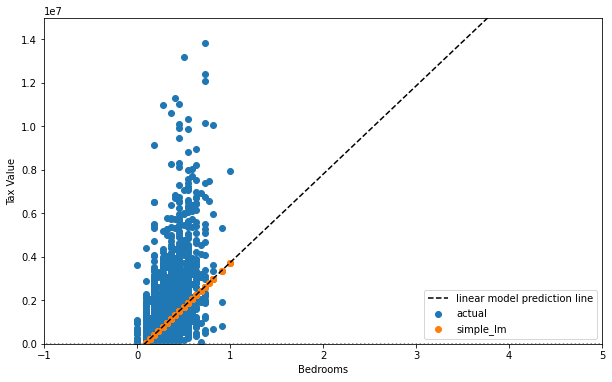

In [13]:
x_pred = np.array([-25, 50]).reshape(-1, 1)
y_pred = lm.predict(x_pred)

plt.figure(figsize=(10, 6))
plt.scatter(trains.bathroomcnt, train.taxvaluedollarcnt, label='actual')
plt.scatter(trains.bathroomcnt, lm.predict(trains[['bathroomcnt']]), label='simple_lm')
plt.plot(x_pred, y_pred, ls='--', c='black', label='linear model prediction line')
plt.hlines(0, -25, 100, ls=':', color='grey')
plt.vlines(0, -10, 100, ls=':', color='grey')
plt.xlim(-1, 5)
plt.ylim(0, 15000000)
plt.xlabel('Bedrooms')
plt.ylabel('Tax Value')
plt.legend()

In [14]:
# tax value = 0.761 * bathroom + 22.003
print(f'For every bathroom, we predict a {lm.coef_[0]:.2f} dollars increase in tax value.')

For every bathroom, we predict a 4063469.91 dollars increase in tax value.


In [15]:
# do the same for finished sqft
# X must be 2-d
X_train = train[['finishedsquarefeet12']]
# y can be 1-d
y_train = train.taxvaluedollarcnt

# 1. make the thing
lm = LinearRegression()
# 2. fit the thing
lm.fit(X_train, y_train)
# 3. use the thing (make predictions)
X_validate = validate[['finishedsquarefeet12']]
predictions['simple_lm'] = lm.predict(X_validate)

In [16]:
predictions.head()

,actual,simple_lm
17073,780176.0,371373.528561
20295,247558.0,362197.564030
20557,346957.0,95657.641944
40782,390842.0,821432.741265
20266,1082260.0,559699.276790


In [17]:
# EVALUATE THE MODEL
lm.coef_, lm.intercept_

(array([436.95069195]), -314639.0577931771)

In [18]:
print('taxvaluedollarcnt = {:.3f} * finishedsquarefeet12 + {:.3f}'.format(lm.coef_[0], lm.intercept_))

taxvaluedollarcnt = 436.951 * finishedsquarefeet12 + -314639.058


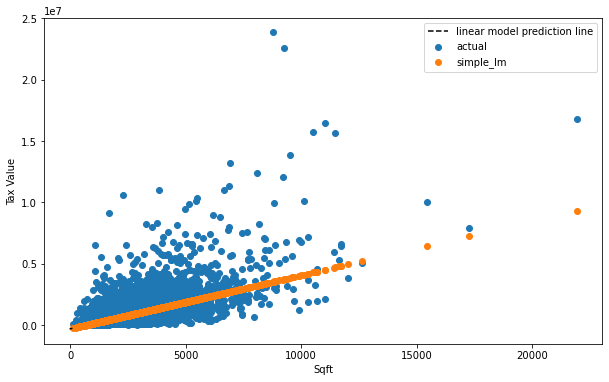

In [19]:
x_pred = np.array([-25, 100]).reshape(-1, 1)
y_pred = lm.predict(x_pred)

plt.figure(figsize=(10, 6))
plt.scatter(train.finishedsquarefeet12, train.taxvaluedollarcnt, label='actual')
plt.scatter(train.finishedsquarefeet12, lm.predict(train[['finishedsquarefeet12']]), label='simple_lm')
plt.plot(x_pred, y_pred, ls='--', c='black', label='linear model prediction line')
plt.hlines(0, -25, 100, ls=':', color='grey')
plt.vlines(0, -10, 100, ls=':', color='grey')

plt.xlabel('Sqft')
plt.ylabel('Tax Value')
plt.legend()

In [20]:
# tax value = 0.761 * sqrft + 22.003
print(f'For every 1 square foot increase, we predict a {lm.coef_[0]:.2f} dollars increase in tax value.')

For every 1 square foot increase, we predict a 436.95 dollars increase in tax value.


In [21]:
## Multiple Regression + RFE
X_train = trains
y_train = train.taxvaluedollarcnt
X_validate = validates

lm = LinearRegression()
k = 2

# 1. Transform our X
rfe = RFE(lm, n_features_to_select=2)
rfe.fit(X_train, y_train)
print('selected top 2 features:', X_train.columns[rfe.support_])
X_train_rfe = rfe.transform(X_train)

# 2. Use the transformed x in our model
lm.fit(X_train_rfe, y_train)

# 3. Make predictions
X_validate_rfe = rfe.transform(X_validate)
predictions['multiple_rfe'] = lm.predict(X_validate_rfe)

predictions.head()

selected top 2 features: Index(['bedroomcnt', 'finishedsquarefeet12'], dtype='object')


,actual,simple_lm,multiple_rfe
17073,780176.0,371373.528561,7.838548e+05
20295,247558.0,362197.564030,6.103670e+05
20557,346957.0,95657.641944,4.080377e+05
40782,390842.0,821432.741265,1.495826e+06
20266,1082260.0,559699.276790,1.146969e+06


In [22]:
X_train.columns[rfe.support_]

Index(['bedroomcnt', 'finishedsquarefeet12'], dtype='object')

In [23]:
lm.coef_, lm.intercept_

(array([-1402159.59157922, 11328152.08778812]), 56587.227589886694)

In [24]:
print(f'tax value = {lm.coef_[0]:.2f} x bedrooms + {lm.coef_[1]:.2f} x square feet + {lm.intercept_:.2f}')

tax value = -1402159.59 x bedrooms + 11328152.09 x square feet + 56587.23


In [25]:
from sklearn.preprocessing import PolynomialFeatures

X_train = trains
y_train = train.taxvaluedollarcnt
X_validate = validates

# 1. Generate Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
poly.fit(X_train)
X_train_poly = pd.DataFrame(
    poly.transform(X_train),
    columns=poly.get_feature_names(X_train.columns),
    index=trains.index,
)
X_train_poly.head()

,bathroomcnt,bedroomcnt,finishedsquarefeet12,garagecarcnt,lotsizesquarefeet,bathroomcnt^2,bathroomcnt bedroomcnt,bathroomcnt finishedsquarefeet12,bathroomcnt garagecarcnt,bathroomcnt lotsizesquarefeet,bedroomcnt^2,bedroomcnt finishedsquarefeet12,bedroomcnt garagecarcnt,bedroomcnt lotsizesquarefeet,finishedsquarefeet12^2,finishedsquarefeet12 garagecarcnt,finishedsquarefeet12 lotsizesquarefeet,garagecarcnt^2,garagecarcnt lotsizesquarefeet,lotsizesquarefeet^2
0,0.181818,0.2,0.056970,0.0,0.000984,0.033058,0.036364,0.010358,0.000000,0.000179,0.04,0.011394,0.0,0.000197,0.003246,0.000000,0.000056,0.0,0.000000,9.673410e-07
1,0.181818,0.3,0.090271,0.0,0.005835,0.033058,0.054545,0.016413,0.000000,0.001061,0.09,0.027081,0.0,0.001750,0.008149,0.000000,0.000527,0.0,0.000000,3.404310e-05
2,0.272727,0.2,0.077107,0.0,0.001112,0.074380,0.054545,0.021029,0.000000,0.000303,0.04,0.015421,0.0,0.000222,0.005945,0.000000,0.000086,0.0,0.000000,1.236384e-06
3,0.454545,0.6,0.173295,0.0,0.002332,0.206612,0.272727,0.078770,0.000000,0.001060,0.36,0.103977,0.0,0.001399,0.030031,0.000000,0.000404,0.0,0.000000,5.440335e-06
4,0.181818,0.3,0.047062,1.0,0.000427,0.033058,0.054545,0.008557,0.181818,0.000078,0.09,0.014119,0.3,0.000128,0.002215,0.047062,0.000020,1.0,0.000427,1.825103e-07


In [26]:
lm = LinearRegression()
lm.fit(X_train_poly, y_train)

X_validate_poly = poly.transform(X_validate)
predictions['polynomial degree 2'] = lm.predict(X_validate_poly)

In [27]:
feature_names = poly.get_feature_names(X_train.columns)
pd.Series(lm.coef_, index=feature_names).sort_values()

garagecarcnt^2                           -3.175046e+17
bathroomcnt lotsizesquarefeet            -1.159787e+07
garagecarcnt lotsizesquarefeet           -9.414324e+06
bathroomcnt bedroomcnt                   -6.390626e+06
bedroomcnt finishedsquarefeet12          -4.414706e+06
finishedsquarefeet12 lotsizesquarefeet   -4.343520e+06
bedroomcnt lotsizesquarefeet             -2.467949e+06
finishedsquarefeet12^2                   -1.137210e+06
finishedsquarefeet12 garagecarcnt        -7.207877e+05
bedroomcnt                               -6.073668e+05
bathroomcnt garagecarcnt                 -3.694445e+05
lotsizesquarefeet^2                      -6.384885e+04
bathroomcnt                               4.384001e+04
bedroomcnt garagecarcnt                   3.482165e+05
bedroomcnt^2                              1.780033e+06
bathroomcnt^2                             2.957882e+06
lotsizesquarefeet                         2.997356e+06
finishedsquarefeet12                      4.518825e+06
bathroomcn

In [28]:
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
poly.fit(X_train)
X_train_poly = pd.DataFrame(
    poly.transform(X_train),
    columns=poly.get_feature_names(X_train.columns),
    index=trains.index,
)
lm = LinearRegression()
lm.fit(X_train_poly, y_train)

X_validate_poly = poly.transform(X_validate)
predictions['polynomial only interaction'] = lm.predict(X_validate_poly)

pd.Series(lm.coef_, index=poly.get_feature_names(X_train.columns)).sort_values()

finishedsquarefeet12 lotsizesquarefeet   -1.023216e+07
garagecarcnt lotsizesquarefeet           -9.232300e+06
bathroomcnt lotsizesquarefeet            -7.324907e+06
bedroomcnt finishedsquarefeet12          -6.927846e+06
bedroomcnt lotsizesquarefeet             -2.722496e+06
bathroomcnt bedroomcnt                   -2.118581e+06
finishedsquarefeet12 garagecarcnt        -7.263458e+05
bathroomcnt garagecarcnt                 -4.043708e+05
bathroomcnt                              -2.220305e+05
bedroomcnt                               -1.134502e+05
garagecarcnt                              2.713878e+04
bedroomcnt garagecarcnt                   3.908259e+05
lotsizesquarefeet                         2.637194e+06
finishedsquarefeet12                      4.615134e+06
bathroomcnt finishedsquarefeet12          2.237322e+07
dtype: float64

In [29]:
# Evaluate the model with baselone
# add a baseline model
predictions['baseline'] = train.taxvaluedollarcnt.mean()

In [30]:
predictions.head()

,actual,simple_lm,multiple_rfe,polynomial degree 2,polynomial only interaction,baseline
17073,780176.0,371373.528561,7.838548e+05,8.095937e+05,7.777516e+05,522009.667781
20295,247558.0,362197.564030,6.103670e+05,4.946798e+05,4.730645e+05,522009.667781
20557,346957.0,95657.641944,4.080377e+05,3.496894e+05,3.496456e+05,522009.667781
40782,390842.0,821432.741265,1.495826e+06,1.156090e+06,1.169001e+06,522009.667781
20266,1082260.0,559699.276790,1.146969e+06,8.299040e+05,8.405265e+05,522009.667781


In [31]:
def calculate_mse(y_predicted):
    return mean_squared_error(predictions.actual, y_predicted)

predictions.apply(calculate_mse)

actual                         0.000000e+00
simple_lm                      3.681490e+11
multiple_rfe                   7.092354e+11
polynomial degree 2            5.938836e+11
polynomial only interaction    6.083831e+11
baseline                       5.724992e+11
dtype: float64

In [32]:
# re-create our polynomial model
X_train = trains
y_train = train.taxvaluedollarcnt

poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
poly.fit(X_train)
X_train_poly = pd.DataFrame(
    poly.transform(X_train),
    columns=poly.get_feature_names(X_train.columns),
    index=trains.index,
)

lm = LinearRegression()
lm.fit(X_train_poly, y_train)

LinearRegression()

In [33]:
X_test = tests
X_test_poly = poly.transform(X_test)

test_predictions = lm.predict(X_test_poly)
test_actual = test.taxvaluedollarcnt

In [34]:
mean_squared_error(test_actual, test_predictions)

320388447896.4197